# Load Model

In [152]:
from keras.models import load_model

saved_model_file = 'cat_dog.h5'
model = load_model(saved_model_file)

# Preprocess

In [153]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 16
valid_datagen = ImageDataGenerator(rescale=1./255)
# this is a similar generator, for validation data
validation_generator = valid_datagen.flow_from_directory(
        'dataset/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

from keras.preprocessing import image
import numpy as np

x_valid = []
for i in validation_generator.filenames:
    img = image.load_img('dataset/validation/'+ i , target_size=(150,150, 3))
    img = image.img_to_array(img)
    img = img/255
    x_valid.append(img)
x_valid = np.array(x_valid)

def create_labels(length): 
    a = []
    for i in range(length):
        if i < length/2:
            a.append(0)
        else:
            a.append(1)
    a = np.array(a)
    return a

y_valid = create_labels(len(x_valid))

from keras.utils import to_categorical

y_valid = to_categorical(y_valid)

Found 2002 images belonging to 2 classes.


# Evaluate model

In [154]:
model.evaluate(x_valid, y_valid)

2002/2002 [==============================] - 8s 4ms/step


[0.7033112422487774, 0.8436563436563437]

# Prepare deeplift model

In [155]:
from os.path import dirname, abspath, join
import sys

sys.path.append('/home/muskaanjain/git/deeplift')

import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc

revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)

nonlinear_mxts_mode is set to: RevealCancel
150
148
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
74
72
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
36
34
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case


# Sanity Check

#### To ensure that the predictions made by the deeplift model are exactly same as the original model

In [156]:
from deeplift.util import compile_func
import numpy as np
from keras import backend as K

deeplift_model = revealcancel_model
deeplift_prediction_func = compile_func([deeplift_model.get_layers()[0].get_activation_vars()],
                                       deeplift_model.get_layers()[-1].get_activation_vars())
original_model_predictions = model.predict(x_valid, batch_size=16)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[x_valid],
                                func=deeplift_prediction_func,
                                batch_size=16,
                                progress_update=None)
print("difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

difference in predictions: 0.0


# Results

### Task 1: To visualise the important features or part of an image responsible for its resulting prediction value.

#### Compute scores for input images

In [157]:
from keras import backend as K
import deeplift
from deeplift.util import get_integrated_gradients_function
from collections import OrderedDict

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

method_to_task_to_scores = OrderedDict()

for method_name, score_func in [('revealcancel', revealcancel_func)]:
    print("Computing scores for:",method_name)
    method_to_task_to_scores[method_name] = {}
    for task_idx in range(2):
        print("\tComputing scores for task: "+str(task_idx))
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[x_valid],
                    input_references_list=[np.zeros_like(x_valid)],
                    batch_size=100,
                    progress_update=None))
        method_to_task_to_scores[method_name][task_idx] = scores

2
OneAndZeros
Computing scores for: revealcancel
	Computing scores for task: 0
	Computing scores for task: 1


In [158]:
#Store the image indices which are predicted right or wrong separately for cats and dogs.
y_pred = (np.array(converted_model_predictions) >= 0.5)*1 + (np.array(converted_model_predictions) < 0.5)*0
predictions = np.argmax(y_pred, axis=1)
original = np.argmax(y_valid, axis=1)

right_cat_pred_idx = []
wrong_cat_pred_idx = []
right_dog_pred_idx = []
wrong_dog_pred_idx = []

for i in range(len(y_valid)):
    if(original[i] == 0):
        if(predictions[i] == 0):
            right_cat_pred_idx.append(i)
        else:
            wrong_cat_pred_idx.append(i)
    else:
        if(predictions[i] == 1):
            right_dog_pred_idx.append(i)
        else:
            wrong_dog_pred_idx.append(i)
            
print("Sanity check :")
print((len(right_cat_pred_idx) + len(right_dog_pred_idx) + len(wrong_cat_pred_idx) + len(wrong_dog_pred_idx)) == len(y_valid))

Sanity check :
True


In [159]:
#Variables and their used values


In [160]:
print("cat predictions:: right : ", len(right_cat_pred_idx), " wrong : ", len(wrong_cat_pred_idx))
print("dog predictions:: right : ", len(right_dog_pred_idx), " wrong : ", len(wrong_dog_pred_idx))

cat predictions:: right :  910  wrong :  91
dog predictions:: right :  779  wrong :  222


In [236]:
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

random_img_set1 = np.empty([2], dtype=int) #right cat images
random_img_set2 = np.empty([5], dtype=int) #wrong cat images
random_img_set3 = np.empty([2], dtype=int) #right dog images
random_img_set4 = np.empty([5], dtype=int) #wrong dog images - no elements in this 

random_img_set1[0] = right_cat_pred_idx[10]
random_img_set1[1] = right_cat_pred_idx[178]


random_img_set2[0] = wrong_cat_pred_idx[1]
random_img_set2[1] = wrong_cat_pred_idx[78]
random_img_set2[2] = wrong_cat_pred_idx[45]
random_img_set2[3] = wrong_cat_pred_idx[34]
random_img_set2[4] = wrong_cat_pred_idx[20]

random_img_set3[0] = right_dog_pred_idx[500]
random_img_set3[1] = right_dog_pred_idx[56]


random_img_set4[0] = wrong_dog_pred_idx[1]
random_img_set4[1] = wrong_dog_pred_idx[78]
random_img_set4[2] = wrong_dog_pred_idx[145]
random_img_set4[3] = wrong_dog_pred_idx[34]
random_img_set4[4] = wrong_dog_pred_idx[220]

In [233]:
print(method_to_task_to_scores['revealcancel'][0].shape)

(2002, 150, 150, 3)


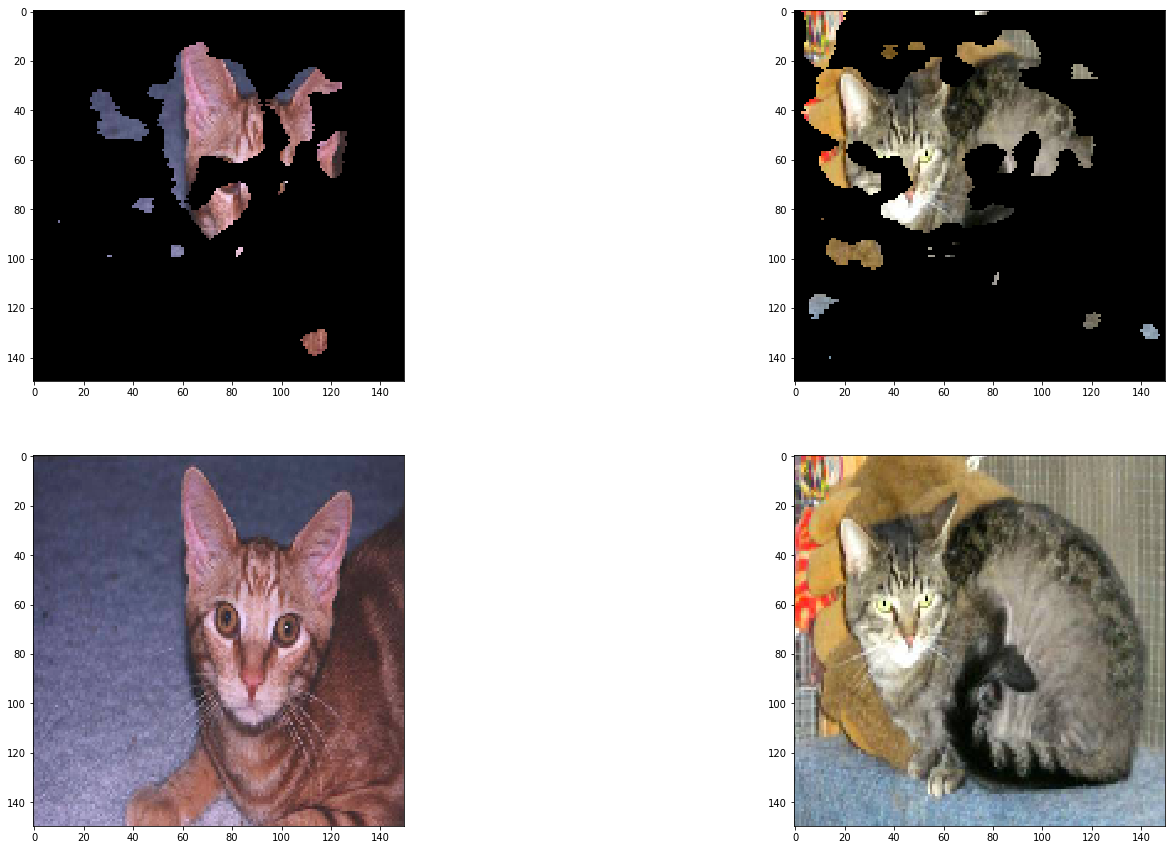

In [234]:
f, axarr = plt.subplots(2, 2, sharey=False, figsize=(25,15))
ix = 0
n_task1 = 10000#erase

for i in random_img_set1:
    s = method_to_task_to_scores['revealcancel'][0][i]
    img = array_to_img(s)
    img = ndimage.gaussian_filter(img, sigma=(4, 4, 0), order=0)
    s = img_to_array(img)
    arr = s.ravel()
    top_nth_threshold = max(sorted(arr, reverse=True)[n_task1],0.0) #can be done before smoothing the scores
    thresholded_points = 1.0*(arr >= top_nth_threshold)
    thresholded_points = thresholded_points.reshape(150, 150, 3)
    thresholded_points = np.array(thresholded_points[:, :, 0])
    thresholded_points = thresholded_points[..., np.newaxis]
    M = np.zeros((150, 150, 3))
    thresholded_points = M + thresholded_points
    imp_inp = thresholded_points*x_valid[i]
    axarr[0][ix].imshow(array_to_img(imp_inp))
    axarr[1][ix].imshow(array_to_img(x_valid[i]))
    ix += 1

Almost in all of the images, cats are being identified by their faces or eyes or ears

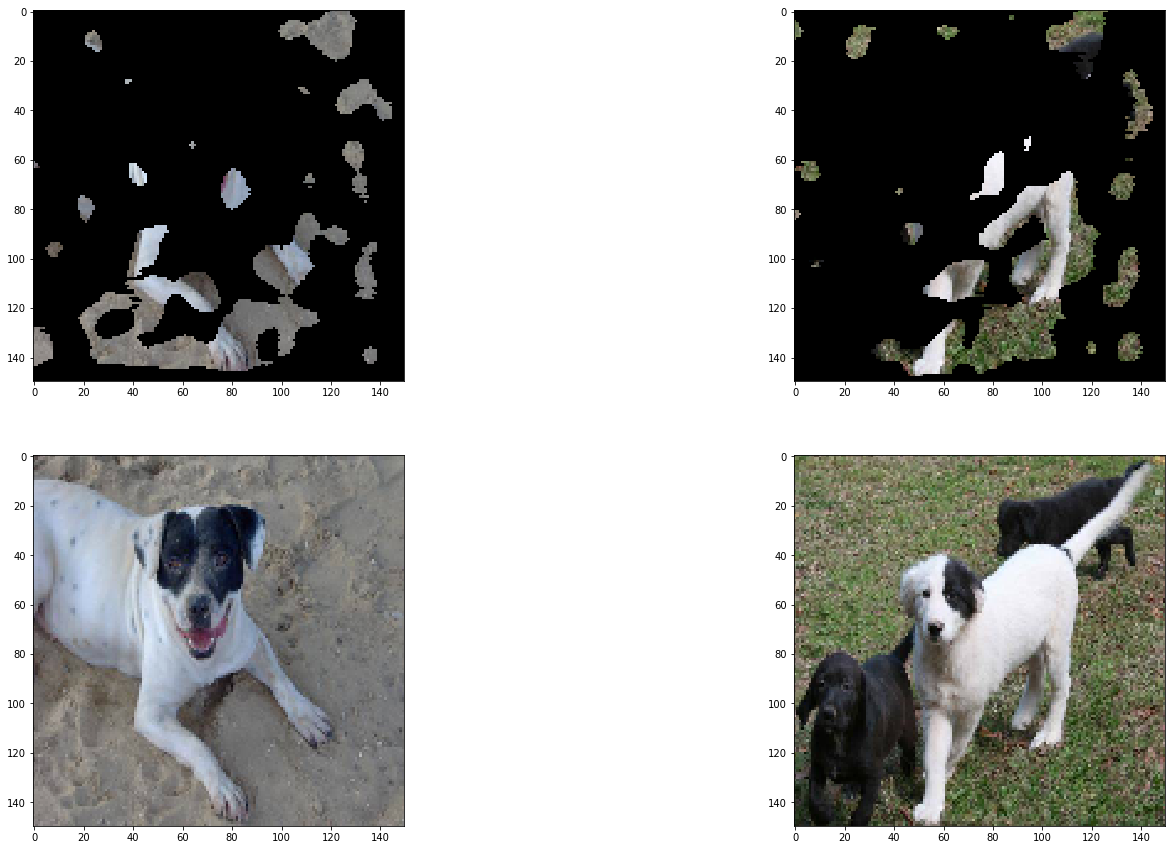

In [241]:
f, axarr = plt.subplots(2, 2, sharey=False, figsize=(25,15))
ix = 0
n_task1 = 15000#erase

for i in random_img_set3:
    s = method_to_task_to_scores['revealcancel'][1][i]
    img = array_to_img(s)
    img = ndimage.gaussian_filter(img, sigma=(4, 4, 0), order=0)
    s = img_to_array(img)
    arr = s.ravel()
    top_nth_threshold = max(sorted(arr, reverse=True)[n_task1],0.0) #can be done before smoothing the scores
    thresholded_points = 1.0*(arr >= top_nth_threshold)
    thresholded_points = thresholded_points.reshape(150, 150, 3)
    thresholded_points = np.array(thresholded_points[:, :, 0])
    thresholded_points = thresholded_points[..., np.newaxis]
    M = np.zeros((150, 150, 3))
    thresholded_points = M + thresholded_points
    imp_inp = thresholded_points*x_valid[i]
    axarr[0][ix].imshow(array_to_img(imp_inp))
    axarr[1][ix].imshow(array_to_img(x_valid[i]))
    ix += 1

Almost in all of the images, dogs are being identified by their legs (don't know the reason)

Note : So, given an image we can find the grids in an image which are important for a certain classification. That means in our case of graphs, if anyhow we can have the information of the subgraphs which are present / reflect a grid, we can say that those subgraphs are actually important for a certain prediction in a graph.

### Task 2: To visualise the features responsible for distinguishing dogs and cats from each other

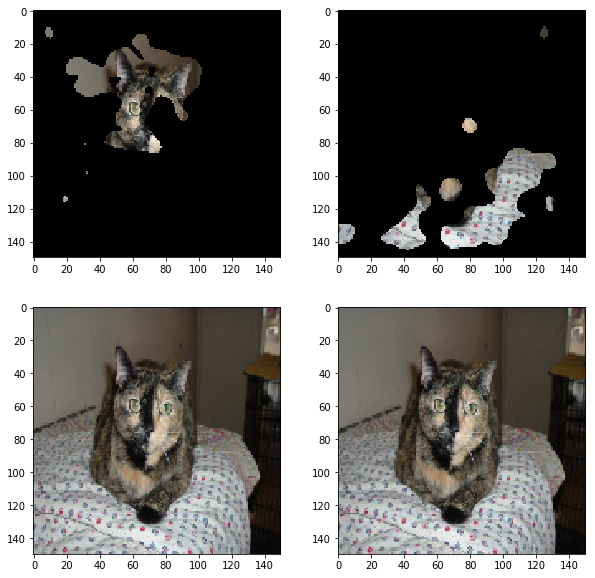

In [255]:
idx = 500
n_to_erase = 10000
s1 = method_to_task_to_scores['revealcancel'][0][idx]
img = array_to_img(s1)
img = ndimage.gaussian_filter(img, sigma=(3, 3, 0), order=0)
s1 = img_to_array(img)

s2 = method_to_task_to_scores['revealcancel'][1][idx]
img = array_to_img(s2)
img = ndimage.gaussian_filter(img, sigma=(3, 3, 0), order=0)
s2 = img_to_array(img)

s = s1 - s2
img = array_to_img(s)
img = ndimage.gaussian_filter(img, sigma=(3, 3, 0), order=0)
s = img_to_array(img)

arr = s.ravel()
top_nth_threshold = max(sorted(arr, reverse=True)[n_to_erase],0.0)
thresholded_points = 1.0*(arr >= top_nth_threshold)
thresholded_points = thresholded_points.reshape(150, 150, 3)
thresholded_points = np.array(thresholded_points[:, :, 0])
thresholded_points = thresholded_points[..., np.newaxis]
M = np.zeros((150, 150, 3))
thresholded_points = M + thresholded_points
imp_inp = thresholded_points*x_valid[idx]

f, axarr = plt.subplots(2, 2, sharey=False, figsize=(10,10))
axarr[0][0].imshow(array_to_img(imp_inp))
axarr[1][0].imshow(array_to_img(x_valid[idx]))



s1 = method_to_task_to_scores['revealcancel'][1][idx]
img = array_to_img(s1)
img = ndimage.gaussian_filter(img, sigma=(3, 3, 0), order=0)
s1 = img_to_array(img)

s2 = method_to_task_to_scores['revealcancel'][0][idx]
img = array_to_img(s2)
img = ndimage.gaussian_filter(img, sigma=(3, 3, 0), order=0)
s2 = img_to_array(img)

s = s1 - s2
img = array_to_img(s)
img = ndimage.gaussian_filter(img, sigma=(3, 3, 0), order=0)
s = img_to_array(img)

arr = s.ravel()
top_nth_threshold = max(sorted(arr, reverse=True)[n_to_erase],0.0)
thresholded_points = 1.0*(arr >= top_nth_threshold)
thresholded_points = thresholded_points.reshape(150, 150, 3)
thresholded_points = np.array(thresholded_points[:, :, 0])
thresholded_points = thresholded_points[..., np.newaxis]
M = np.zeros((150, 150, 3))
thresholded_points = M + thresholded_points
imp_inp = thresholded_points*x_valid[idx]

axarr[0][1].imshow(array_to_img(imp_inp))
axarr[1][1].imshow(array_to_img(x_valid[idx]))


 The features responsible for differentiating the above image from the dog is its face.
 And the features which are important for predicting this as a dog but not the cat 
 is something random, that can be reason why this image has not been predicted as a dog but a cat.

Note : In the scenario of graphs, along with the information of subgraphs which are actually important for its certain prediction, we can also identify the subgraphs among those which are important for a particular class over the other class.

Note : We can also remove the noises in the chosen important features as above if the images form using the subgraphs have the same grid relation as the grids above has i.e. if a grid is not important that its nearby grids are also not.

### Task 3: Top influential High Level features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15_input (InputLayer) (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_23 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 32)        9248      
Total params: 10,144
Trainable params: 10,144
Non-trainable params: 0
_________________________________________________________________
(1, 72, 72, 32)


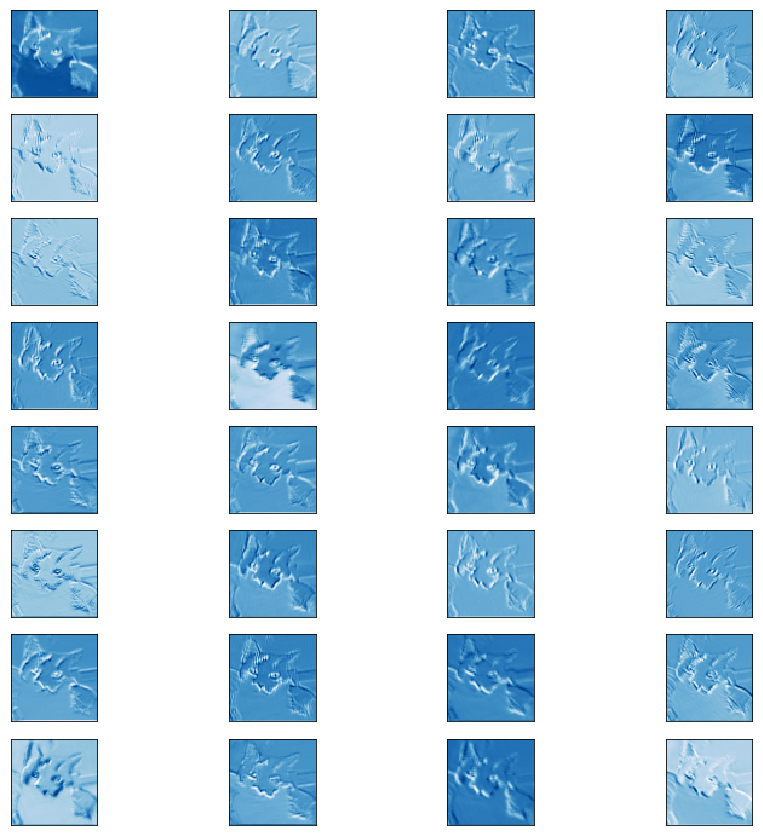

In [257]:
from keras.models import Model
from numpy import expand_dims

layer_no = 3
model1 = Model(inputs=model.inputs, outputs=model.layers[layer_no].output)
model1.summary()

idx = 1000
# get feature map for first hidden layer
img = x_valid[idx].reshape(1, 150, 150, 3)
feature_maps = model1.predict(img)
print(feature_maps.shape)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
f, axarr = plt.subplots(8, 4, sharey=False, figsize=(15,15))

for i in range(8):
    for j in range(4):
        ax = axarr[i][j]
        # specify subplot and turn of axis
      
        
        # plot filter channel in grayscale
        ax.imshow(feature_maps[0, :, :, ix-1], cmap='Blues')
        ax.set_xticks([])
        ax.set_yticks([])
        ix += 1
# show the figure
plt.show()

These are the features extracted at the fourth layer of the model from a cat image.

Brightness of a feature in any of the feature map shows that that pixel has been extracted from the image.

In most of the feature maps the features that has been extracted is the boundary lines of the shape of the cat that can be seen highlighted in above images

In [258]:
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=layer_no+1, target_layer_idx=-2)

method_to_task_to_scores = OrderedDict()

for method_name, score_func in [('revealcancel', revealcancel_func)]:
    print("Computing scores for:",method_name)
    method_to_task_to_scores[method_name] = {}
    for task_idx in range(2):
        print("\tComputing scores for task: "+str(task_idx))
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[x_valid],
                    input_references_list=[np.zeros_like(x_valid)],
                    batch_size=100,
                    progress_update=None))
        method_to_task_to_scores[method_name][task_idx] = scores

nonlinear_mxts_mode is set to: RevealCancel
150
148
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
74
72
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
36
34
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
2
OneAndZeros
Computing scores for: revealcancel
	Computing scores for task: 0
	Computing scores for task: 1


0.0013403939847152495 -0.0014707641339906802 5.9270095445154825e-05 0.0010135790322913778
2


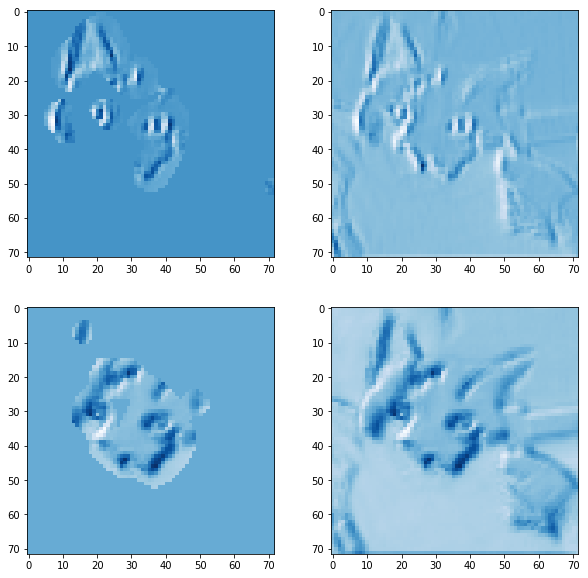

In [262]:
task_idx1 = 0
task_idx2 = 1
width = 72
height =72
filters = 32
n = 1000
#1000
masked_scores = np.empty([width, height, filters])
for i in range(filters):
    s1 = method_to_task_to_scores['revealcancel'][task_idx1][idx][:, :, i]
    #s1 = ndimage.gaussian_filter(s1, sigma=(3, 3), order=0)
    
    s2 = method_to_task_to_scores['revealcancel'][task_idx2][idx][:, :, i]
    #s2 = ndimage.gaussian_filter(s2, sigma=(3, 3), order=0)
    
    s = s1 - s2
    s = ndimage.gaussian_filter(s, sigma=(3, 3), order=0)
    
    masked_scores[:, :, i] = s
    
s_avg = np.empty([filters])
for i in range(filters):
    s_avg[i] = (np.sum(masked_scores[:, :, i]))/(width*height)

top_n = np.percentile(s_avg, 96.77)
print(np.max(s_avg), np.min(s_avg), np.mean(s_avg), top_n)
num = 0
selected_filters = []
for i in range(filters):
    if(s_avg[i]>=top_n):
        num = num + 1
        selected_filters.append(i)
print(num)

f, axarr = plt.subplots(num, 2 , figsize=(10,10))
ix = 0
for i in selected_filters:
    arr = masked_scores[:, :, i].ravel()
    top_nth_threshold = max(sorted(arr, reverse=True)[n],0.0)
    thresholded_points = 1.0*(arr >= top_nth_threshold)
    thresholded_points = thresholded_points.reshape(width, height)

    imp_inp = thresholded_points[:, :]*feature_maps[0, :, :, i]
    axarr[ix][0].imshow(imp_inp, cmap='Blues')
    axarr[ix][1].imshow(feature_maps[0, :, :, i], cmap='Blues')
    ix = ix + 1

These are the top two high level features which have the highest importance scores or say are most influential parts of the above image.

Note : I chose a feature map in a given layer which has maximum average importance score for a particular image. Then after identifying the important feature map as for example above is a feature map of size 72x72 extracted fom an image of size 150x150x3, we can identify the important pixel in this feature map and can easily visualise it. 

But in the case of subgraphs, visualisations of such high level features is not necessary that that will make sense until unless that is not backpropagated to the input image(what i think as of now). Till now I wasn't able to find anything on the net which can map a high level feature to its input image clearly(if you have any suggestion or ny other approach or I will try to look into this further).

### Task 4: Most important neuron in a layer for whole set of a class

In [288]:
feature_maps = model1.predict(x_valid)
#print(feature_maps.shape)
task = 0
n_to_erase = 15000
width = 72
height =72
filters = 32
filter_score = np.zeros([filters])
percent = 5
for i in range(len(x_valid)):
    s = method_to_task_to_scores['revealcancel'][task][i]
    #s = ndimage.gaussian_filter(s, sigma=3, order=0)

    arr = s.ravel()
    top_nth_threshold = max(sorted(arr, reverse=True)[n_to_erase],0.0)
    thresholded_points = 1.0*(arr >= top_nth_threshold)
    thresholded_points = thresholded_points.reshape(width, height, filters)
    points = []

    for i in range(filters):
        points.append(np.sum(thresholded_points[:, :, i]))

    top_n = np.percentile(points, 100 - percent)
    #print(np.max(points), np.min(points), np.mean(points), top_n)
    num = 0
    selected_filters = []
    for i in range(filters):
        if(points[i]>=top_n):
            num = num + 1
            selected_filters.append(i)
    #print(num)

    for i in selected_filters:
        filter_score[i] += 1
        
#print("score of filters: ", filter_score)

filter_percent = 5
top_filters_value = np.percentile(points, 100 - filter_percent)
#print(top_filters_value)

top_filters = []
for i in range(filters):
    if(filter_score[i]>=top_filters_value):
        num = num + 1
        top_filters.append(i)
#print(num)

#print(top_filters)
for i in top_filters:
    print("filter no: ", i, " filter score: ", filter_score[i])
    
#print(sorted(filter_score, reverse=True))

filter no:  15  filter score:  737.0
filter no:  24  filter score:  1337.0


In [289]:
task = 1
n_to_erase = 15000
width = 72
height =72
filters = 32
filter_score = np.zeros([filters])
percent = 5
img_thres = []
for i in range(len(x_valid)):
    s = method_to_task_to_scores['revealcancel'][task][i]
    arr = s.ravel()
    top_nth_threshold = max(sorted(arr, reverse=True)[n_to_erase],0.0)
    img_thres.append(top_nth_threshold)
    thresholded_points = 1.0*(arr >= top_nth_threshold)
    thresholded_points = thresholded_points.reshape(width, height, filters)
    points = []

    for i in range(filters):
        points.append(np.sum(thresholded_points[:, :, i]))

    top_n = np.percentile(points, 100 - percent)
    #print(np.max(points), np.min(points), np.mean(points), top_n)
    num = 0
    selected_filters = []
    for i in range(filters):
        if(points[i]>=top_n):
            num = num + 1
            selected_filters.append(i)
    #print(num)

    for i in selected_filters:
        filter_score[i] += 1
        
#print("score of filters: ", filter_score)

filter_percent = 5
top_filters_value = np.percentile(points, 100 - filter_percent)
#print(top_filters_value)

top_filters = []
for i in range(filters):
    if(filter_score[i]>=top_filters_value):
        num = num + 1
        top_filters.append(i)
#print(num)

#print(top_filters)
for i in top_filters:
    print("filter no: ", i, " filter score: ", filter_score[i])
    
#print(sorted(filter_score, reverse=True))

filter no:  13  filter score:  1669.0
filter no:  18  filter score:  1392.0


Note : Here again I don't know a method for now, of how to trace the high level features back to its input image.